In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Loading test output from the model and converting to time index

filename = r'Brunei_Champion_GT5_tst_pred_01Dec2018_01Jul2019.csv'
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv(filename, parse_dates = ['timestamp'], date_parser = dateparse)
df.set_index('timestamp', inplace = True)
df['date'] = df.index


In [4]:
# Changing -1 to 1 and 1 to 0 [1 denotes anomaly, 0 denotes normal]

df.prediction = df.prediction.replace(1, 0)
df.prediction = df.prediction.replace(-1, 1)

df['anomaly'] = 0
df.loc[(df['system_status'] == 'online') & (df['prediction'] == 1), 'anomaly'] = 1

df['normal'] = 0
df.loc[(df['system_status'] == 'online') & (df['prediction'] == 0), 'normal'] = 1

df['sys_status'] = 0
df.loc[(df['system_status'] == 'online'), 'sys_status'] = 1
df.loc[(df['system_status'] == 'offline'), 'sys_status'] = 0

df['flips'] = 0
df.loc[(df['system_status'] == 'online') & (df['alert'] == 1) & (df['prediction'] == 1), 'flips'] = 1

df['counter_flips'] = 0
df.loc[(df['system_status'] == 'online') & (df['alert'] == 0) & (df['prediction'] == 1), 'counter_flips'] = 1


In [5]:
## Creating results dataframe

resultsdf = df[['anomaly','flips','counter_flips', 'normal','sys_status']].resample('W').sum()
resultsdf.columns = ['anomaly_count','flips_count','counter_flips_count', 'model_uptime_count','online_status_count']

x = df[['prediction', 'sys_status']].resample('W').count()

resultsdf['Total_counts'] = x['prediction']

resultsdf['anomaly_ratio'] = resultsdf['anomaly_count'] / resultsdf['Total_counts']
resultsdf['flips_ratio'] = resultsdf['flips_count'] / resultsdf['Total_counts']
resultsdf['counter_flips_ratio'] = resultsdf['counter_flips_count'] / resultsdf['Total_counts']
resultsdf['model_uptime_ratio'] = resultsdf['model_uptime_count'] / resultsdf['Total_counts']
resultsdf ['machine availability'] =  (resultsdf['online_status_count']/ (x['sys_status'])) * 100


In [6]:
resultsdf.drop(resultsdf.tail(1).index, inplace = True)
len(resultsdf) #datapoints  

31

In [7]:
#resultsdf.to_csv('results.csv')

In [9]:
filename1 = r'results.csv'
#dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
df1 = pd.read_csv(filename1, parse_dates = ['timestamp'])
df1.set_index('timestamp', inplace = True)

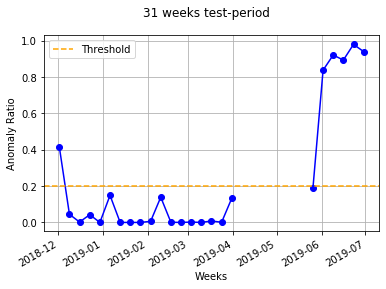

In [13]:
fig, ax = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)
fig.suptitle('31 weeks test-period', fontsize = 12)

ax.plot(df1.index, df1['anomaly_ratio'], linestyle = '-', marker = 'o', color = 'b')
ax.axhline(0.2, color = 'orange', linestyle = '--', label = 'Threshold')
ax.set_xlabel('Weeks')
ax.set_ylabel('Anomaly Ratio')
ax.grid(True)
ax.legend()

plt.show()

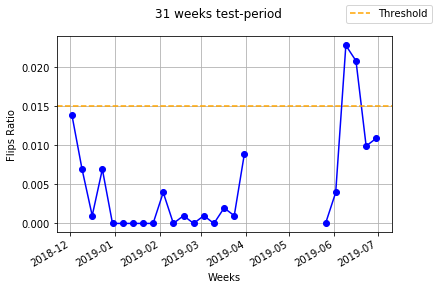

In [14]:
fig, ax = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)
fig.suptitle('31 weeks test-period', fontsize = 12)

ax.plot(df1.index, df1['flips_ratio'], linestyle = '-', marker = 'o', color = 'b')
ax.axhline(0.015, color = 'orange', linestyle = '--', label = 'Threshold')
#ax.set_ylim([-0.01, 0.1])
ax.set_xlabel('Weeks')
ax.set_ylabel('Flips Ratio')
ax.grid(True)
fig.legend()

plt.show()

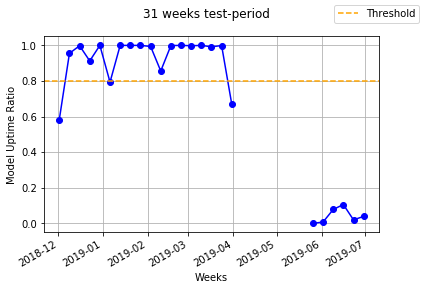

In [15]:
fig, ax = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)
fig.suptitle('31 weeks test-period', fontsize = 12)

ax.plot(df1.index, df1['model_uptime_ratio'], linestyle = '-', marker = 'o', color = 'b')
ax.axhline(0.8, color = 'orange', linestyle = '--', label = 'Threshold')
ax.set_xlabel('Weeks')
ax.set_ylabel('Model Uptime Ratio')
ax.grid(True)
fig.legend()

plt.show()

<IPython.core.display.Javascript object>


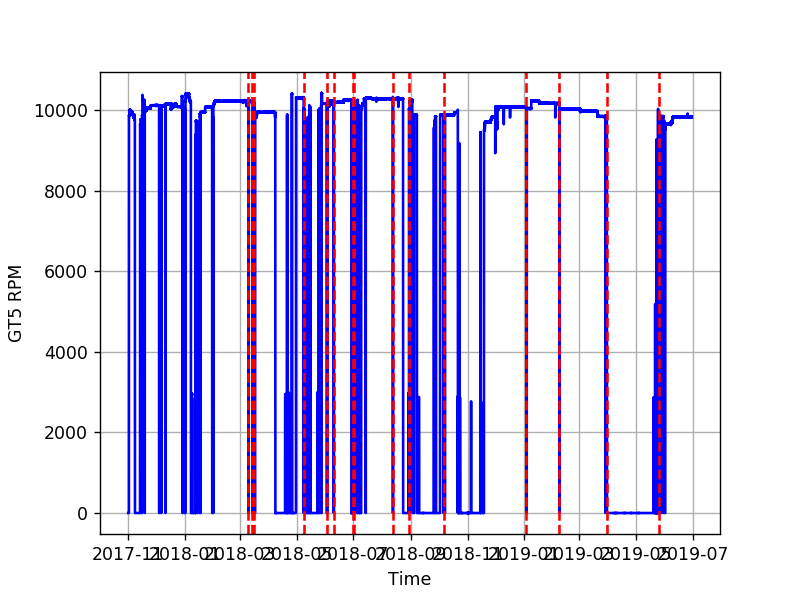

In [19]:
# Plotting entire dataset 

%matplotlib notebook

#dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
#pdf = pd.read_csv(r'gt4_master_data.csv', parse_dates=['timestamp'], date_parser = dateparse)
pdf = pd.read_csv(r'GT5_tags_masterdata.csv', parse_dates = ['timestamp'])
pdf.set_index('timestamp', inplace = True)

# Loading events_log 

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
dffailure = pd.read_excel(r'GT5-downtime.xlsx', parse_dates = ['Trip Start Date'], date_parser = dateparse)
pdf = pdf[pdf.index <= resultsdf.index[-1]]

fig, ax1 = plt.subplots()

ax1.plot(pdf['CPCX07-DCS-GT5_XZA5754_NEW'], 'b-', label = 'GT5 RPM')
ax1.set_xlabel('Time')
ax1.set_ylabel('GT5 RPM')
#ax1.legend()
ax1.grid(True)
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')

plt.xticks(fontsize = 10)
plt.show()


In [20]:
# Reloading the failure dataframe

dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
dffailure = pd.read_excel(r'GT5-downtime.xlsx', parse_dates = ['Trip Start Date'], date_parser = dateparse)
dffailure = dffailure[dffailure['Trip Start Date'] >= resultsdf.index[0]]
dffailure = dffailure[dffailure['Trip Start Date'] <= resultsdf.index[-1]]


<IPython.core.display.Javascript object>


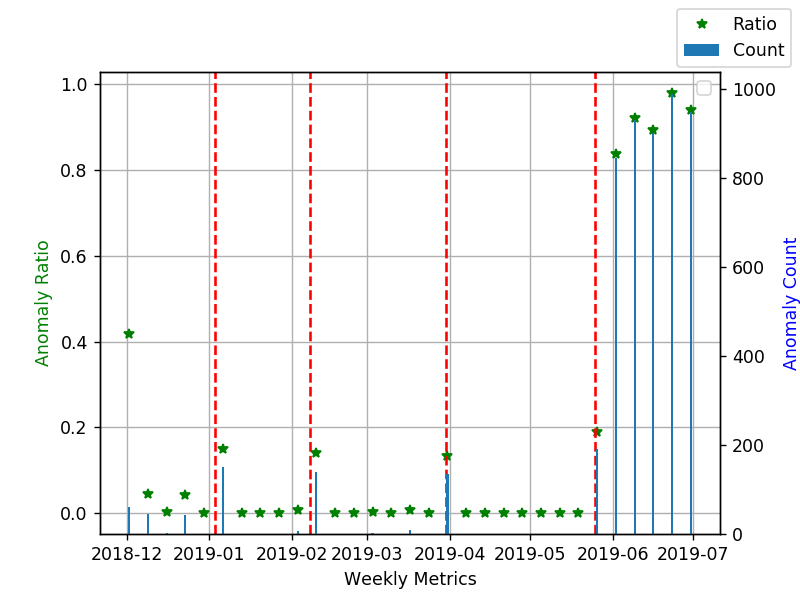

In [21]:
# Create anomaly ratio plot

%matplotlib notebook

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(resultsdf['anomaly_ratio'], 'g*', label = 'Ratio')
ax2.bar(resultsdf.index,resultsdf['anomaly_count'], label = 'Count')
ax1.set_xlabel('Weekly Metrics')
ax1.set_ylabel('Anomaly Ratio', color = 'g')
ax2.set_ylabel('Anomaly Count', color = 'b')
ax1.grid(True)
#ax2.grid('off')
fig.legend()
ax1.legend('Ratio','Count')
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')


plt.show() 

<IPython.core.display.Javascript object>


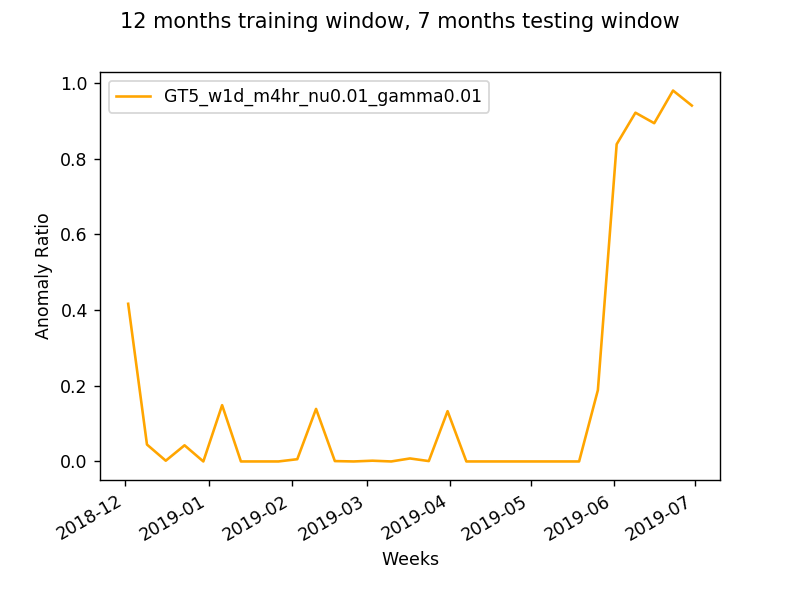

In [12]:
%matplotlib notebook

fig, ax = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)
fig.suptitle('12 months training window, 7 months testing window', fontsize = 12)

#plt.bar(resultsdf.index, resultsdf['anomaly_ratio'], width = 5.0, label = "GT5_w1d_m4hr_nu0.01_gamma0.01")
ax.set_xlabel('Weeks')
ax.set_ylabel('Anomaly Ratio')
plt.plot(resultsdf.index, resultsdf['anomaly_ratio'], linestyle = '-', color='orange', label = "GT5_w1d_m4hr_nu0.01_gamma0.01")
#ax.grid()
ax.legend()

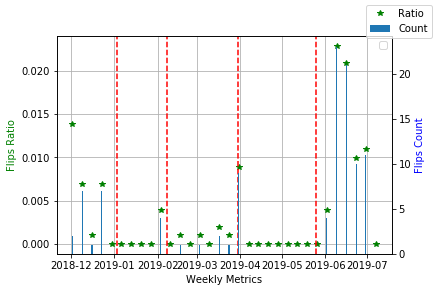

In [9]:
# Create flips ratio plot


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(resultsdf['flips_ratio'], 'g*', label = 'Ratio')
ax2.bar(resultsdf.index, resultsdf['flips_count'], label = 'Count')

ax1.set_xlabel('Weekly Metrics')
ax1.set_ylabel('Flips Ratio', color = 'g')
ax2.set_ylabel('Flips Count', color = 'b')
ax1.grid(True)
#ax2.grid('off') 
fig.legend()
ax1.legend('Ratio','Count')
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')


plt.show()

<IPython.core.display.Javascript object>


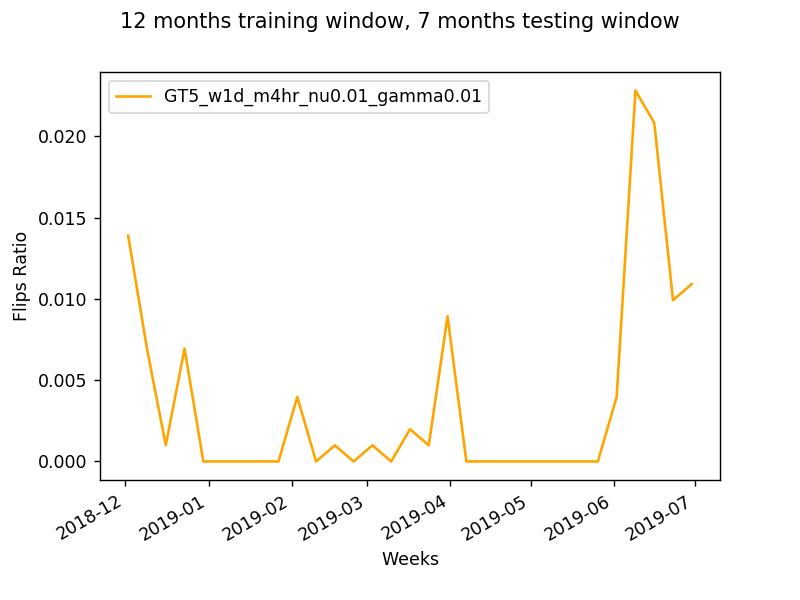

In [11]:
fig, ax = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)
fig.suptitle('12 months training window, 7 months testing window', fontsize = 12)

#plt.bar(resultsdf.index, resultsdf['flips_ratio'], width = 5.0, label = "GT5_w1d_m4hr_nu0.01_gamma0.01")
ax.set_xlabel('Weeks')
ax.set_ylabel('Flips Ratio')
plt.plot(resultsdf.index, resultsdf['flips_ratio'], linestyle = '-', color = 'orange', label = "GT5_w1d_m4hr_nu0.01_gamma0.01")
#ax.grid()
ax.legend()

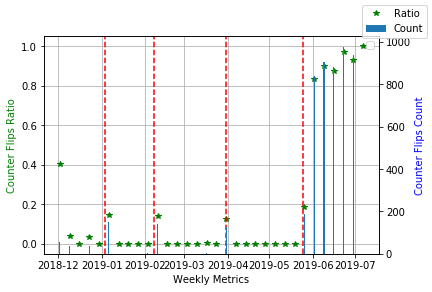

In [10]:
# Create counter_flips ratio plot

#%matplotlib notebook

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(resultsdf['counter_flips_ratio'], 'g*',label = 'Ratio')
ax2.bar(resultsdf.index, resultsdf['counter_flips_count'], label = 'Count')

ax1.set_xlabel('Weekly Metrics')
ax1.set_ylabel('Counter Flips Ratio', color = 'g')
ax2.set_ylabel('Counter Flips Count', color = 'b')
ax1.grid(True)
#ax2.grid('off')
fig.legend()
ax1.legend('Ratio','Count')
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')


plt.show()

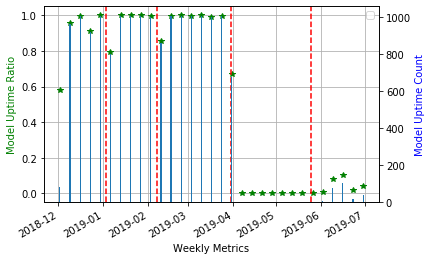

In [9]:
# Create model_uptime_ratio plot

#%matplotlib inline

fig, ax1 = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)

ax2 = ax1.twinx()
ax1.plot(resultsdf['model_uptime_ratio'], 'g*', label = 'Ratio')
ax2.bar(resultsdf.index, resultsdf['model_uptime_count'], label = 'Count')

ax1.set_xlabel('Weekly Metrics')
ax1.set_ylabel('Model Uptime Ratio', color = 'g')
ax2.set_ylabel('Model Uptime Count', color = 'b')
ax1.grid(True)
#ax2.grid('off') 
#fig.legend()
ax1.legend('Ratio','Count')
for cnt in range(len(dffailure)):
    ax1.axvline(x = dffailure.loc[dffailure.index[cnt],'Trip Start Date'], color = 'r', linestyle = '--')


plt.show()

<IPython.core.display.Javascript object>


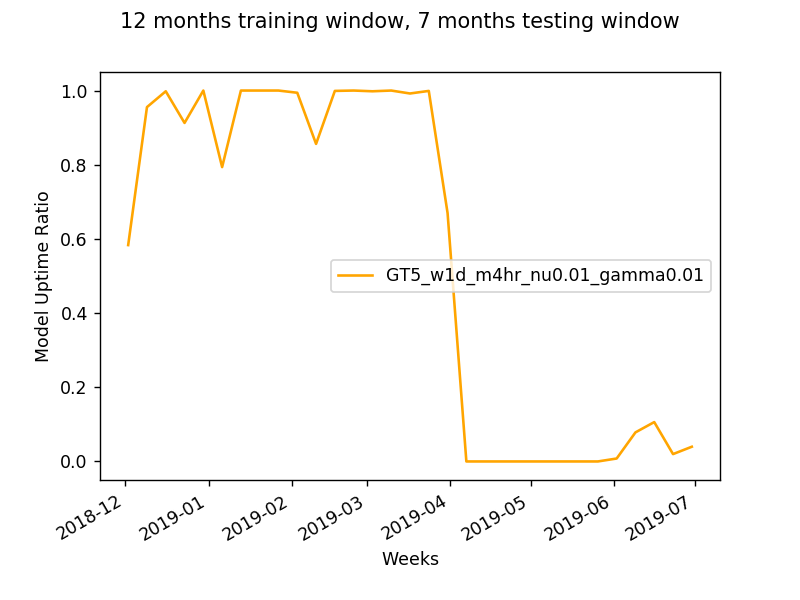

In [10]:
fig, ax = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)
fig.suptitle('12 months training window, 7 months testing window', fontsize = 12)

#plt.bar(resultsdf.index, resultsdf['model_uptime_ratio'], width = 5.0, label = "GT5_w1d_m4hr_nu0.01_gamma0.01")
ax.set_xlabel('Weeks')
ax.set_ylabel('Model Uptime Ratio')
plt.plot(resultsdf.index, resultsdf['model_uptime_ratio'], linestyle = '-', color = 'orange', label = "GT5_w1d_m4hr_nu0.01_gamma0.01")
#ax.grid()
ax.legend()

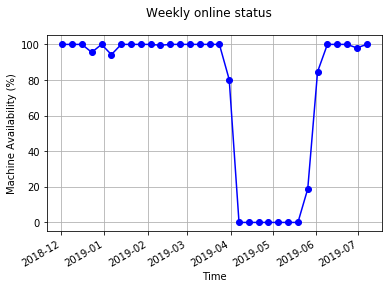

In [11]:
fig, ax = plt.subplots()
fig.autofmt_xdate(bottom = 0.2, rotation = 30)
fig.suptitle('Weekly online status', fontsize = 12)

ax.plot(resultsdf['machine availability'], linestyle = '-', marker = 'o', color = 'b')

ax.set_xlabel('Time')
ax.set_ylabel('Machine Availability (%)')
ax.grid(True)
#fig.legend('')

plt.show()

In [15]:
#resultsdf.head(10)

In [11]:
#resultsdf.to_csv('results.csv')

In [12]:
# Validate counts from the test data output file (monthly)

df[['anomaly','flips','counter_flips','normal', 'sys_status']].resample('M').sum()

,anomaly,flips,counter_flips,normal,sys_status
timestamp,,,,,
2018-12-31,150,17,133,4125,4275
2019-01-31,155,3,152,4251,4406
2019-02-28,142,2,140,3885,4027
2019-03-31,145,13,132,4120,4265
2019-04-30,0,0,0,0,0
2019-05-31,819,4,815,8,827
2019-06-30,3982,65,3917,246,4228
2019-07-31,1,0,1,0,1
